# Location patterns 1 - global chromosome characteristics

This notebook explores the relationship between inversion coordinates and chromosome characteristics related to recombination rates. 



In [67]:
# Initiate notebook with packages

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import scipy.stats
import math
from plotnine import ggplot, geom_histogram, aes, geom_bar, scale_x_discrete, theme, element_text, ggtitle, xlab, ylab, geom_point, stat_smooth, annotate


## Raw data upload

In [16]:
# Load chromosome data

gap = pd.read_csv('../data/raw/gap.txt', sep = '\t', header = None )
gap.set_axis(['bin','chrom','chromStart','chromEnd','ix','n','size','type','bridge'], axis = 1, inplace = True)


band = pd.read_csv('../data/raw/cytoBand.txt', sep = '\t', header = None )
band.set_axis(['chrom','chromStart','chromEnd','name','gieStain'], axis = 1, inplace = True)

# Load and clean inversion data

inv = pd.read_csv('../data/use/InversionsAnnotation_133Inv_20211117.csv', sep = '\t', skiprows=1, skip_blank_lines=True)
inv = inv.iloc[:,[0,1,2,11,12,13,14]]
inv = inv.dropna()

print("We will be analyzing " + str(inv.shape[0]) + " inversions")


We will be analyzing 135 inversions


## General distribution by chromosomes

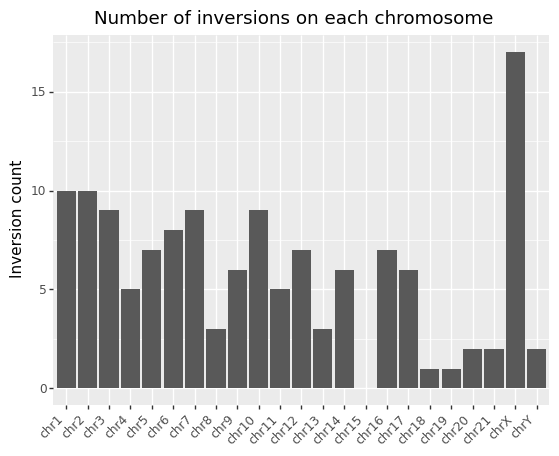

<ggplot: (8747774513475)>

In [15]:
# Make barplot values 
hist = DataFrame(inv.Chr.value_counts())

# Set chromosome names list
a = np.char.array(list(map(str,range(1,22)))+["X", "Y"])
b = np.char.array(["chr"] * 23)
chrNames = b+a 

# Make plot 
(
    ggplot(hist)+
        geom_bar(aes(x = hist.index, y = "Chr"), stat="identity")+
        scale_x_discrete(limits = chrNames)+
        theme( axis_text_x = element_text(angle = 45, vjust = 1, hjust=1))+
        ylab("Inversion count")+
        ggtitle("Number of inversions on each chromosome")

)



## Relationship with chromosome size

In [70]:
# Take chromosome sizes
chromSize = gap[(gap.type == "telomere") & (gap.chromStart!=0)][["chrom", "chromEnd"]]

# Join with inversion count
prop = pd.merge(chromSize, hist, left_on="chrom", right_index=True)

# Calculate correlation between chrom size and inversion count
# np.corrcoef(prop["chromEnd"],prop.Chr)
# corr = scipy.stats.pearsonr(prop.chromEnd, prop.Chr)
# corrMessage = "Pearson's r = {:.3f}; p-value = {:.3f}".format(corr[0], corr[1])

# Plot correlation
(
    # ggplot(prop)+
    ggplot(prop[~prop["chrom"].isin(["chrX", "chrY"])])+
    stat_smooth(aes(x = "chromEnd", y = "Chr"), method = "lm") +    
    geom_point(aes(x = "chromEnd", y = "Chr")) +
    annotate('text', x = math.inf, y = -math.inf, label = "hello", hjust = 0, vjust = 1)

)

PlotnineError: "Parameters {'hjust', 'vjust'}, are not understood by either the geom, stat or layer."

pandas.core.series.Series

## Relative position within chromosome

In [ ]:
# Select centromeres as p arm End
center = band[(band['gieStain'] == 'acen') & (band['name'].str.startswith('p') )]
center = center[['chrom', 'chromEnd']]

# Select chromosome end as q arm End
groupedBand = band['chromEnd'].groupby(band['chrom'])
end = DataFrame(groupedBand.max() )
end.reset_index(level=['chrom'], inplace = True)

# Set q arm Start
end = pd.merge(end, center, on = 'chrom')
end.set_axis(['chrom','chromEnd','chromStart'], axis = 1, inplace = True)

# Set p arm Start
center['chromStart'] = 0

# Set p and q flags
center['chromArm']='p'
end['chromArm']='q'

# Join data
chromArms = pd.concat([center, end])


## Distribution within chromosome and inversion groups

## Relationship with chromosome mean recombination rate
